# Baichuan-13B 命名实体识别微调

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。


传统上，一般把NLP的研究领域大致分为自然语言理解（NLU）和自然语言生成（NLG）两种。

NLU侧重于如何理解文本，包括文本分类、命名实体识别、指代消歧、句法分析、机器阅读理解等；

NLG则侧重于理解文本后如何生成自然文本，包括自动摘要、机器翻译、问答系统、对话机器人等。

但是以ChatGPT为代表的大模型出来后，这些传统的NLP的细分研究领域基本可以说都失去了独立研究的价值。

为什么呢？因为大模型可以用统一的范式通通将它们搞定，并且效果非常出众。


在之前的例子中，我们演示了使用QLoRA算法来对BaiChuan-13B实施微调以处理最简单的文本分类任务。

在外卖评论数据集上，微调后测试集acc由0.8925提升到0.9015约提升了1个百分点。

在本例中，我们使用几乎相同的流程和方法来微调BaiChuan-13B以更好地处理命名实体识别任务。

实验结果显示，微调前，我们的f1-score仅仅是0.4313，微调后，取得了明显的提升，达到了0.8768。

注：跑完本流程需要至少32G的CPU，需要约2个小时的训练时间。



在我们正式开始之前，请允许我用简短的话给没有NLP基础知识的小伙伴讲解一下什么是命名实体识别。

命名实体识别NER任务是NLP的一个常见基础任务，

它是Named Entity Recognization的简称。

简单地说，就是识别一个句子中的各种 名称实体，诸如：人名，地名，机构 等。

例如对于下面这句话：

```
小明对小红说:"你听说过安利吗？"
```

其命名实体可以抽取表示如下：

```
{"人名": ["小明","小红"], "组织": ["安利"]}
```

In [ ]:
#安装环境

#baichuan-13b-chat
#!pip install 'transformers==4.30.2'
#!pip install  -U transformers_stream_generator


#finetune
#!pip install datasets
#!pip install git+https://github.com/huggingface/accelerate
#!pip install  git+https://github.com/huggingface/peft
#!pip install  git+https://github.com/lyhue1991/torchkeras 
#!pip install 'bitsandbytes==0.39.1' #4bit量化

## 〇，预训练模型

我们需要从 https://huggingface.co/baichuan-inc/Baichuan-13B-Chat 下载baichuan-13b-chat的模型。

国内可能速度会比较慢，总共有25个G左右，网速不太好的话，大概可能需要两到三个小时。

如果网络不稳定，也可以手动从这个页面一个一个下载全部文件然后放置到 一个文件夹中例如 'baichuan-13b' 以便读取。


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='../baichuan-13b' #远程 'baichuan-inc/Baichuan-13B-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


[2023-07-22 20:32:37,605] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from IPython.display import clear_output 
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是哪座?"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)
    
    

乔戈里峰。世界第二高峰———乔戈里峰海拔高度：8610米坐标：35.5°n,76.5°e乔戈里，蒙古语意为“高大雄伟”，它位于喀喇昆仑山脉的中部。


下面我们设计一个7-shot-prompt方法，测试一下BaiChuan13b的实体抽取能力。

In [4]:
prefix = '''命名实体识别：抽取文本中的 人名，地点，组织 这三类命名实体，并按照json格式返回结果。

下面是一些范例：

小明对小红说:"你听说过安利吗？" -> {"人名": ["小明","小红"], "组织": ["安利"]}
现在，每年有几十万中国人到美国访问，几千名中国留学生到美国就学。 -> {"地点": ["中国", "美国"]}
中国是联合国安理会常任理事国之一。 -> {"地点": ["中国"], "组织": ["联合国"]}

请对下述文本进行实体抽取，返回json格式。

'''

def get_prompt(text):
    return prefix+text+' -> '

def get_message(prompt,response):
    return [{"role": "user", "content": f'{prompt} -> '},
            {"role": "assistant", "content": response}]


In [5]:
messages  = [{"role": "user", "content": get_prompt("一些摩洛哥球迷已按捺不住，在看台上欢呼雀跃")}]
response = model.chat(tokenizer, messages)
print(response)


{"地点":["摩洛哥"], "组织":[]}


In [6]:
messages = messages+[{"role": "assistant", "content": "{'地点': ['摩洛哥']}"}]
messages.extend(get_message("这次轮到北京国安队，不知会不会再步后尘？","{'组织': ['北京国安队']}"))
messages.extend(get_message("革命党人孙中山在澳门成立同盟会分会","{'人名': ['孙中山'], '地名': ['澳门'], '组织': ['同盟会']}"))
messages.extend(get_message("我曾在安徽芜湖市和上海浦东打工。","{'地点': ['安徽芜湖市', '上海浦东']}"))
display(messages)


[{'role': 'user',
  'content': '命名实体识别：抽取文本中的 人名，地点，组织 这三类命名实体，并按照json格式返回结果。\n\n下面是一些范例：\n\n小明对小红说:"你听说过安利吗？" -> {"人名": ["小明","小红"], "组织": ["安利"]}\n现在，每年有几十万中国人到美国访问，几千名中国留学生到美国就学。 -> {"地点": ["中国", "美国"]}\n中国是联合国安理会常任理事国之一。 -> {"地点": ["中国"], "组织": ["联合国"]}\n\n请对下述文本进行实体抽取，返回json格式。\n\n一些摩洛哥球迷已按捺不住，在看台上欢呼雀跃 -> '},
 {'role': 'assistant', 'content': "{'地点': ['摩洛哥']}"},
 {'role': 'user', 'content': '这次轮到北京国安队，不知会不会再步后尘？ -> '},
 {'role': 'assistant', 'content': "{'组织': ['北京国安队']}"},
 {'role': 'user', 'content': '革命党人孙中山在澳门成立同盟会分会 -> '},
 {'role': 'assistant',
  'content': "{'人名': ['孙中山'], '地名': ['澳门'], '组织': ['同盟会']}"},
 {'role': 'user', 'content': '我曾在安徽芜湖市和上海浦东打工。 -> '},
 {'role': 'assistant', 'content': "{'地点': ['安徽芜湖市', '上海浦东']}"}]

In [7]:
def predict(text,temperature=0.01):
    model.generation_config.temperature=temperature
    response = model.chat(tokenizer, 
                          messages = messages+[{'role':'user','content':f'{text} -> '}])
    return response


In [8]:
predict('杜甫是李白的粉丝。') 

"{'人名': ['杜甫', '李白']}"

我们拿一个开源的中文NER数据集来测试一下未经微调，仅仅使用7-shot-prompt的预训练模型的效果。

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd 

df = pd.read_pickle('dfner_13k.pkl')
dfdata,dftest = train_test_split(df,test_size=300,random_state=42)
dftrain,dfval = train_test_split(dfdata,test_size=200,random_state=42)

In [50]:
preds = ['' for x in dftest['target']]
for i in tqdm(range(len(preds))):
    preds[i] = predict(dftest['text'].iloc[i])
    

  0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
def toset(s):
    try:
        dic = eval(str(s))
        res = []
        for k,v in dic.items():
            for x in v:
                if x:
                    res.append((k,x))
        return set(res)
    except Exception as err:
        print(err)
        return set()

In [ ]:
dftest['pred'] = [toset(x) for x in preds]
dftest['gt'] = [toset(x) for x in dftest['target']]
dftest['tp_cnt'] = [len(pred&gt) for pred,gt in zip(dftest['pred'],dftest['gt'])]
dftest['pred_cnt'] = [len(x) for x in dftest['pred']]
dftest['gt_cnt'] = [len(x) for x in dftest['gt']]

precision = sum(dftest['tp_cnt'])/sum(dftest['pred_cnt'])
print('precision = '+str(precision))

recall = sum(dftest['tp_cnt'])/sum(dftest['gt_cnt'])
print('recall = '+str(recall))

f1 = 2*precision*recall/(precision+recall)
print('f1_score = '+str(f1))


precision = 0.4316109422492401
recall = 0.45151033386327505
f1_score = 0.44133644133644134


微调前 f1_score为 0.44 

## 一，准备数据

我们仿照百川模型的 `model._build_chat_input` 方法来进行token编码，同时把需要学习的内容添加label.

### 1，token编码

In [11]:
import torch 

#将messages编码成 token, 同时返回labels
#注意baichuan-13b通过插入tokenizer.user_token_id和tokenizer.assistant_token_id 来区分用户和机器人会话内容

# reference@ model._build_chat_input?
def build_chat_input(messages, model=model,
                     tokenizer=tokenizer, 
                     max_new_tokens: int=0):
    max_new_tokens = max_new_tokens or model.generation_config.max_new_tokens
    max_input_tokens = model.config.model_max_length - max_new_tokens
    max_input_tokens = max(model.config.model_max_length // 2, max_input_tokens)
    
    total_input, round_input, total_label, round_label = [], [], [], []
    
    for i, message in enumerate(messages[::-1]):
        content_tokens = tokenizer.encode(message['content'])
        if message['role'] == 'user':
            round_input = [model.generation_config.user_token_id] + content_tokens + round_input
            round_label = [-100]+[-100 for _ in content_tokens]+ round_label
            
            if total_input and len(total_input) + len(round_input) > max_input_tokens:
                break
            else:
                total_input = round_input + total_input
                total_label = round_label + total_label
                if len(total_input) >= max_input_tokens:
                    break
                else:
                    round_input = []
                    round_label = []
                    
        elif message['role'] == 'assistant':
            round_input = [
                model.generation_config.assistant_token_id
            ] + content_tokens + [
                model.generation_config.eos_token_id
            ] + round_input
            
            if i==0: #仅对最后一轮的target进行学习
                round_label = [
                    -100
                ] + content_tokens + [
                    model.generation_config.eos_token_id
                ]+ round_label
            else:
                round_label = [
                    -100
                ] + [-100 for _ in content_tokens] + [
                    -100
                ]+ round_label
                
        else:
            raise ValueError(f"message role not supported yet: {message['role']}")
            
    total_input = total_input[-max_input_tokens:]  # truncate left
    total_label = total_label[-max_input_tokens:]
    
    total_input.append(model.generation_config.assistant_token_id)
    total_label.append(-100)
    
    return total_input,total_label



### 2，做数据集

In [12]:
from torch.utils.data import Dataset,DataLoader 
from copy import deepcopy
class MyDataset(Dataset):
    def __init__(self,df,
                 messages
                ):
        self.df = df 
        self.messages = messages
        
    def __len__(self):
        return len(self.df)
        
    def get_samples(self,index):
        samples = []
        d = dict(self.df.iloc[index])
        samples.append(d)
        return samples
    
    def get_messages(self,index):
        samples = self.get_samples(index)
        messages = deepcopy(self.messages)
        for i,d in enumerate(samples):

            messages.append({'role':'user','content':d['text']+' -> '})
            messages.append({'role':'assistant','content':str(d['target'])})
        return messages
        
    def __getitem__(self,index):
        messages = self.get_messages(index)
        input_ids, labels = build_chat_input(messages)
        return {'input_ids':input_ids,'labels':labels}

    def show_sample(self,index):
        samples = self.get_samples(index)
        print(samples)
    
    

In [13]:
ds_train = MyDataset(dftrain,messages)
ds_val = MyDataset(dfval,messages)


In [14]:
ds_train.show_sample(0)

[{'text': '包括中国在内的近30个国家的政府官员和经济专家参加了这次为期两天的研讨会。', 'target': {'地点': ['中国']}}]


In [16]:
print(ds_train[0])

{'input_ids': [195, 31106, 31710, 31313, 19529, 7254, 77, 32482, 31509, 31271, 31267, 3026, 20134, 31313, 72, 8021, 72, 2858, 12477, 31318, 31548, 31710, 31313, 19529, 72, 31404, 4201, 14013, 20983, 17965, 4021, 73, 5, 5, 7810, 31161, 2719, 31751, 31530, 77, 5, 5, 31222, 31333, 31209, 31222, 31641, 31263, 18706, 31203, 17510, 31230, 31291, 31447, 31763, 75, 31157, 11531, 1396, 31157, 31167, 31313, 5308, 29567, 31222, 31333, 15286, 31222, 31641, 31157, 5902, 966, 2858, 5308, 29567, 31291, 31447, 14507, 31277, 5, 2272, 72, 9437, 31169, 17271, 31456, 17966, 31195, 3366, 24749, 72, 31612, 31918, 31313, 1572, 25090, 31195, 3366, 31194, 31181, 73, 11531, 1396, 31157, 8021, 5308, 29567, 1572, 2286, 966, 3366, 14507, 31277, 5, 1572, 31161, 6583, 31200, 31291, 31240, 31190, 31349, 31424, 23942, 31200, 5760, 73, 11531, 1396, 31157, 8021, 5308, 29567, 1572, 31157, 5902, 966, 2858, 5308, 29567, 6583, 31200, 14507, 31277, 5, 5, 31488, 31209, 31214, 32193, 31271, 31267, 1696, 19529, 32482, 31509, 72

### 3，创建管道

In [17]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [18]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train,num_workers=2,batch_size=1,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)

dl_val = torch.utils.data.DataLoader(ds_val,num_workers=2,batch_size=1,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [19]:
for batch in dl_train:
    break 

In [20]:
#试跑一个batch
out = model(**batch)

In [21]:
out.loss 

tensor(1.3135, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [22]:
len(dl_train)

5000

In [23]:
#采样300个batch作为一个epoch，便于较快验证
dl_train.size = 300

## 二，定义模型

下面我们将使用QLoRA(实际上用的是量化的AdaLoRA）算法来微调Baichuan-13b模型。

In [24]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [25]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [26]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)


In [27]:
lora_modules = find_all_linear_names(model)
print(lora_modules) 


['down_proj', 'gate_proj', 'W_pack', 'o_proj', 'up_proj']


In [28]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=16,
    lora_alpha=16, lora_dropout=0.05,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 41,843,040 || all params: 7,002,181,160 || trainable%: 0.5975715144165165


In [29]:
out = peft_model.forward(**batch)

In [30]:
out[0]

tensor(1.3118, grad_fn=<ToCopyBackward0>)

## 三，训练模型

In [31]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

#仅仅保存QLora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [32]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-05,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer) 
ckpt_path = 'baichuan13b_ner'



<<<<<< ⚡️ cuda is used >>>>>>


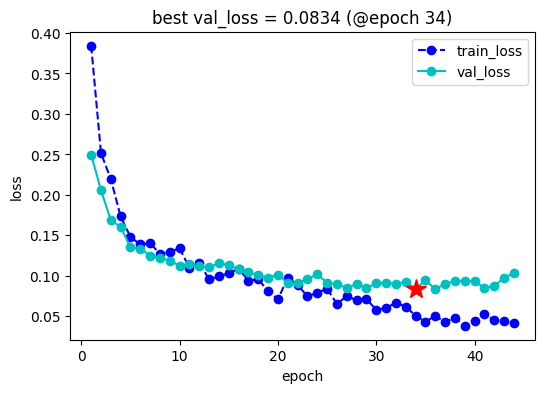

<<<<<< val_loss without improvement in 10 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,0.384217,0.00006,0.249804
1,2,0.251601,0.00006,0.205617
2,3,0.219351,0.00006,0.168795
3,4,0.173330,0.00006,0.160446
4,5,0.147875,0.00006,0.135188
5,6,0.138851,0.00006,0.133749
6,7,0.140442,0.00006,0.125064
7,8,0.127080,0.00006,0.121878
8,9,0.129889,0.00006,0.118764
9,10,0.133962,0.00006,0.112397


In [33]:
# keras_model.load_ckpt(ckpt_path) #支持加载微调后的权重继续训练(断点续训)
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=10,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )


## 四，保存模型

为减少GPU压力，此处可重启kernel释放显存

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
model_name_or_path ='../baichuan-13b'
ckpt_path = 'baichuan13b_ner'
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    trust_remote_code=True
)
model_old = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map='auto'
)


[2023-07-22 23:30:48,987] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

#可能需要5分钟左右
peft_model = PeftModel.from_pretrained(model_old, ckpt_path)
model_new = peft_model.merge_and_unload()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


In [4]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

In [5]:
from IPython.display import clear_output
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是什么？"})
response = model_new.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

乔戈里峰。世界第二高峰———乔戈里峰西方登山者称其为k2峰，海拔高度是8611米，位于喀喇昆仑山脉的中巴边境上.


In [6]:
save_path = 'baichuan-13b-ner'

In [7]:
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

In [9]:
!cp ../baichuan-13b/*.py  baichuan-13b-ner

## 五，使用模型

为减少GPU压力，此处可再次重启kernel释放显存。

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

model_name_or_path = 'baichuan-13b-ner'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


[2023-07-23 00:02:25,962] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from IPython.display import clear_output
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是什么？"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

乔戈里峰。世界第二高峰———乔戈里峰海拔高度：8610米登山难度：死亡率：5.


我们测试一下微调后的效果。

In [3]:
import pandas as pd 
import numpy as np 
import datasets 
from tqdm import tqdm 


In [4]:
prefix = '''命名实体识别：抽取文本中的 人名，地点，组织 这三类命名实体，并按照json格式返回结果。

下面是一些范例：

小明对小红说:"你听说过安利吗？" -> {"人名": ["小明","小红"], "组织": ["安利"]}
现在，每年有几十万中国人到美国访问，几千名中国留学生到美国就学。 -> {"地点": ["中国", "美国"]}
中国是联合国安理会常任理事国之一。 -> {"地点": ["中国"], "组织": ["联合国"]}

请对下述文本进行实体抽取，返回json格式。

'''

def get_prompt(text):
    return prefix+text+' -> '

def get_message(prompt,response):
    return [{"role": "user", "content": f'{prompt} -> '},
            {"role": "assistant", "content": response}]


In [5]:
messages  = [{"role": "user", "content": get_prompt("一些摩洛哥球迷已按捺不住，在看台上欢呼雀跃")}]
response = model.chat(tokenizer, messages)
print(response)


{'人名': ['摩洛哥']}


In [6]:
messages = messages+[{"role": "assistant", "content": "{'地点': ['摩洛哥']}"}]
messages.extend(get_message("这次轮到北京国安队，不知会不会再步后尘？","{'组织': ['北京国安队']}"))
messages.extend(get_message("革命党人孙中山在澳门成立同盟会分会","{'人名': ['孙中山'], '地名': ['澳门'], '组织': ['同盟会']}"))
messages.extend(get_message("我曾在安徽芜湖市和上海浦东打工。","{'地点': ['安徽芜湖市', '上海浦东']}"))
display(messages)


[{'role': 'user',
  'content': '命名实体识别：抽取文本中的 人名，地点，组织 这三类命名实体，并按照json格式返回结果。\n\n下面是一些范例：\n\n小明对小红说:"你听说过安利吗？" -> {"人名": ["小明","小红"], "组织": ["安利"]}\n现在，每年有几十万中国人到美国访问，几千名中国留学生到美国就学。 -> {"地点": ["中国", "美国"]}\n中国是联合国安理会常任理事国之一。 -> {"地点": ["中国"], "组织": ["联合国"]}\n\n请对下述文本进行实体抽取，返回json格式。\n\n一些摩洛哥球迷已按捺不住，在看台上欢呼雀跃 -> '},
 {'role': 'assistant', 'content': "{'地点': ['摩洛哥']}"},
 {'role': 'user', 'content': '这次轮到北京国安队，不知会不会再步后尘？ -> '},
 {'role': 'assistant', 'content': "{'组织': ['北京国安队']}"},
 {'role': 'user', 'content': '革命党人孙中山在澳门成立同盟会分会 -> '},
 {'role': 'assistant',
  'content': "{'人名': ['孙中山'], '地名': ['澳门'], '组织': ['同盟会']}"},
 {'role': 'user', 'content': '我曾在安徽芜湖市和上海浦东打工。 -> '},
 {'role': 'assistant', 'content': "{'地点': ['安徽芜湖市', '上海浦东']}"}]

In [7]:
def predict(text,temperature=0.01):
    model.generation_config.temperature=temperature
    response = model.chat(tokenizer, 
                          messages = messages+[{'role':'user','content':f'{text} -> '}])
    return response


In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd 

df = pd.read_pickle('dfner_13k.pkl')
dfdata,dftest = train_test_split(df,test_size=300,random_state=42)
dftrain,dfval = train_test_split(dfdata,test_size=200,random_state=42)


In [14]:
preds = ['' for x in dftest['target']]
for i in tqdm(range(len(preds))):
    preds[i] = predict(dftest['text'].iloc[i])

100%|██████████| 300/300 [10:42<00:00,  2.14s/it]  


In [16]:
def toset(s):
    try:
        dic = eval(str(s))
        res = []
        for k,v in dic.items():
            for x in v:
                if x:
                    res.append((k,x))
        return set(res)
    except Exception as err:
        print(err)
        return set()

In [17]:
dftest['pred'] = [toset(x) for x in preds]
dftest['gt'] = [toset(x) for x in dftest['target']]
dftest['tp_cnt'] = [len(pred&gt) for pred,gt in zip(dftest['pred'],dftest['gt'])]
dftest['pred_cnt'] = [len(x) for x in dftest['pred']]
dftest['gt_cnt'] = [len(x) for x in dftest['gt']]

precision = sum(dftest['tp_cnt'])/sum(dftest['pred_cnt'])
print('precision = '+str(precision))

recall = sum(dftest['tp_cnt'])/sum(dftest['gt_cnt'])
print('recall = '+str(recall))

f1 = 2*precision*recall/(precision+recall)
print('f1_score = '+str(f1))

EOL while scanning string literal (<string>, line 1)
precision = 0.9139280125195618
recall = 0.8427128427128427
f1_score = 0.876876876876877


微调后的f1_score为0.8768，相比微调前的f1_score=0.44，取得了不可忽视的巨大提升。

以上。

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)